In [1]:
# 02_modeling.ipynb
# Block 1: Setup, imports, and load data

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import json
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True
sns.set(style="whitegrid")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Paths
csv_path = Path("/content/provider_features_clean.csv")  # as you uploaded
metadata_path = Path("/content/features_metadata.json")  # optional, if available

# Load main dataset
provider_df = pd.read_csv(csv_path)
print("Loaded provider_features_clean:", provider_df.shape)

# Try loading metadata if it exists
if metadata_path.exists():
    with open(metadata_path, "r") as f:
        metadata = json.load(f)
    id_column = metadata.get("id_column", "Provider")
    target_column = metadata.get("target_column", "Target")
    feature_columns = metadata.get(
        "feature_columns",
        [c for c in provider_df.columns if c not in ["Provider", "Target"]]
    )
    print("Loaded metadata.")
else:
    print("Metadata file not found. Using defaults.")
    id_column = "Provider"
    target_column = "Target"
    feature_columns = [c for c in provider_df.columns if c not in [id_column, target_column]]

print("ID column:", id_column)
print("Target column:", target_column)
print("Number of features:", len(feature_columns))

display(provider_df.head())


Loaded provider_features_clean: (5410, 70)
Loaded metadata.
ID column: Provider
Target column: Target
Number of features: 68


,Provider,Target,inp_InscClaimAmtReimbursed_mean,inp_InscClaimAmtReimbursed_sum,inp_InscClaimAmtReimbursed_min,inp_InscClaimAmtReimbursed_max,inp_DeductibleAmtPaid_mean,inp_DeductibleAmtPaid_sum,inp_DeductibleAmtPaid_min,inp_DeductibleAmtPaid_max,...,out_ClmProcedureCode_5_mean,out_ClmProcedureCode_5_sum,out_ClmProcedureCode_5_min,out_ClmProcedureCode_5_max,out_ClmProcedureCode_6_mean,out_ClmProcedureCode_6_sum,out_ClmProcedureCode_6_min,out_ClmProcedureCode_6_max,out_n_claims,out_n_bene
0,PRV51001,No,19400.000000,97000.0,3000.0,42000.0,1068.0,5340.0,1068.0,1068.0,...,4139.0,0.0,4139.0,4139.0,NaN,0.0,NaN,NaN,5.0,5.0
1,PRV51003,Yes,9241.935484,573000.0,0.0,57000.0,1068.0,66216.0,1068.0,1068.0,...,4139.0,0.0,4139.0,4139.0,NaN,0.0,NaN,NaN,62.0,53.0
2,PRV51004,No,9484.693085,77000.0,3000.0,24000.0,1068.0,8544.0,1068.0,1068.0,...,4139.0,0.0,4139.0,4139.0,NaN,0.0,NaN,NaN,8.0,7.0
3,PRV51005,Yes,9484.693085,77000.0,3000.0,24000.0,1068.0,8544.0,1068.0,1068.0,...,4139.0,0.0,4139.0,4139.0,NaN,0.0,NaN,NaN,8.0,7.0
4,PRV51007,No,6333.333333,19000.0,3000.0,10000.0,1068.0,3204.0,1068.0,1068.0,...,4139.0,0.0,4139.0,4139.0,NaN,0.0,NaN,NaN,3.0,3.0


# **Modeling Decisions:**
# Data Split:
We chose a 70/30 split to ensure the test set is large enough (approx. 1,600 providers) to capture rare fraud cases reliably.

# Stratification:
We used stratified splitting to maintain the 90:10 non-fraud to fraud ratio in both sets.

# Metric Selection:
Since fraud is rare, Accuracy is misleading. We prioritize ROC-AUC and PR-AUC (Precision-Recall AUC) to minimize missed fraud cases (False Negatives).

In [2]:
# Block 2: Define features/target and create train/test split

from sklearn.model_selection import train_test_split

# Use the columns we defined in Block 1
X = provider_df[feature_columns].copy()
y = provider_df[target_column].copy()

print("X shape:", X.shape)
print("y shape:", y.shape)

print("\nTarget distribution (full dataset):")
print(y.value_counts())
print("\nTarget proportions (full dataset):")
print(y.value_counts(normalize=True))

# Train/test split (stratified to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("\nTrain shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

print("\nTrain target distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest target distribution:")
print(y_test.value_counts(normalize=True))


X shape: (5410, 68)
y shape: (5410,)

Target distribution (full dataset):
Target
No     4904
Yes     506
Name: count, dtype: int64

Target proportions (full dataset):
Target
No     0.90647
Yes    0.09353
Name: proportion, dtype: float64

Train shapes: (4328, 68) (4328,)
Test shapes: (1082, 68) (1082,)

Train target distribution:
Target
No     0.906423
Yes    0.093577
Name: proportion, dtype: float64

Test target distribution:
Target
No     0.906654
Yes    0.093346
Name: proportion, dtype: float64


In [3]:
# Block 3 (Updated): 70/30 Split, Hyperparameter Tuning, and Comparison

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

# 1. Define Features and Target
X = provider_df[feature_columns].copy()
y = provider_df[target_column].copy()

# 2. Perform 70/30 Train-Test Split
print("Splitting data 70% Training / 30% Testing...")
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y  # Keeps the fraud percentage balanced
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# 3. Logistic Regression with GridSearch (Tuning C Penalty)
print("\nTuning Logistic Regression...")
lr_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(random_state=42, class_weight="balanced", max_iter=1000))
])

# Dictionary of C penalties to try
param_grid = {
    "clf__C": [0.001, 0.01, 0.1, 1, 10, 100]
}

lr_search = GridSearchCV(lr_pipeline, param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
lr_search.fit(X_train, y_train)
best_lr_model = lr_search.best_estimator_

print(f"Best LR Params: {lr_search.best_params_}")

# 4. Random Forest (Standard Configuration)
print("Training Random Forest...")
rf_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced", n_jobs=-1))
])
rf_model.fit(X_train, y_train)

# 5. Generate Comparison Table
def get_metrics(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Handle "Yes" labels for metrics
    pos_label = "Yes" if "Yes" in y_test.values else 1
    y_test_bin = (y_test == pos_label).astype(int)

    return {
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, pos_label=pos_label),
        "recall": recall_score(y_test, y_pred, pos_label=pos_label),
        "f1": f1_score(y_test, y_pred, pos_label=pos_label),
        "roc_auc": roc_auc_score(y_test_bin, y_proba)
    }

# Collect results
results = []
results.append(get_metrics(best_lr_model, X_test, y_test, "LogisticRegression"))
results.append(get_metrics(rf_model, X_test, y_test, "RandomForest"))

# Create final DataFrame
results_df = pd.DataFrame(results).set_index("model")

print("\nModel Comparison Results:")
display(results_df)

Splitting data 70% Training / 30% Testing...
Train shape: (3787, 68), Test shape: (1623, 68)

Tuning Logistic Regression...
Best LR Params: {'clf__C': 10}
Training Random Forest...

Model Comparison Results:


,accuracy,precision,recall,f1,roc_auc
model,,,,,
LogisticRegression,0.878004,0.412214,0.710526,0.521739,0.850160
RandomForest,0.923598,0.632075,0.440789,0.519380,0.803808


In [4]:
# Block 4: Tree-based model - Random Forest (Corrected)

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

# --- FIX: Define positive_label explicitly ---
# In the previous block, this might have been local to a function.
# We explicitly set it to "Yes" (the Fraud class).
positive_label = "Yes"

# Pipeline: impute -> random forest (no scaling needed)
rf_clf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=RANDOM_STATE,  # Ensure Block 1 was run for this
        class_weight="balanced",
        n_jobs=-1
    ))
])

# Train
rf_clf.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

# Metrics
acc_rf  = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf, pos_label=positive_label)
rec_rf  = recall_score(y_test, y_pred_rf, pos_label=positive_label)
f1_rf   = f1_score(y_test, y_pred_rf, pos_label=positive_label)

# For ROC AUC, reuse binary y_test
y_test_bin = (y_test == positive_label).astype(int)
auc_rf  = roc_auc_score(y_test_bin, y_proba_rf)

print("Random Forest - Test performance")
print("--------------------------------")
print("Accuracy :", acc_rf)
print("Precision:", prec_rf)
print("Recall   :", rec_rf)
print("F1-score :", f1_rf)
print("ROC AUC  :", auc_rf)

print("\nClassification report:")
print(classification_report(y_test, y_pred_rf))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest - Test performance
--------------------------------
Accuracy : 0.9235982747997535
Precision: 0.6320754716981132
Recall   : 0.4407894736842105
F1-score : 0.5193798449612403
ROC AUC  : 0.8038078285448497

Classification report:
              precision    recall  f1-score   support

          No       0.94      0.97      0.96      1471
         Yes       0.63      0.44      0.52       152

    accuracy                           0.92      1623
   macro avg       0.79      0.71      0.74      1623
weighted avg       0.91      0.92      0.92      1623

Confusion matrix:
[[1432   39]
 [  85   67]]


In [5]:
# Block 5: Compare Logistic Regression vs Random Forest (Corrected)

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 1. Define Positive Label (Fraud)
positive_label = "Yes"

# 2. Recalculate Logistic Regression Metrics
# We use 'best_lr_model' from Block 3.
# If that block named it differently, we check for 'log_reg_clf' as a backup.
if 'best_lr_model' in locals():
    lr_model = best_lr_model
elif 'log_reg_clf' in locals():
    lr_model = log_reg_clf
else:
    raise ValueError("Logistic Regression model not found. Please re-run Block 3.")

# Generate predictions for LR
y_pred_lr = lr_model.predict(X_test)
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]
y_test_bin = (y_test == positive_label).astype(int)

# Calculate scores
acc_lr  = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr, pos_label=positive_label)
rec_lr  = recall_score(y_test, y_pred_lr, pos_label=positive_label)
f1_lr   = f1_score(y_test, y_pred_lr, pos_label=positive_label)
auc_lr  = roc_auc_score(y_test_bin, y_proba_lr)

# 3. Create the Comparison DataFrame
results = pd.DataFrame({
    "model": ["LogisticRegression", "RandomForest"],
    "accuracy": [acc_lr, acc_rf],
    "precision": [prec_lr, prec_rf],
    "recall": [rec_lr, rec_rf],
    "f1": [f1_lr, f1_rf],
    "roc_auc": [auc_lr, auc_rf],
}).set_index("model")

print("Model comparison on test set:")
display(results)

# 4. Choose Best Model (by ROC AUC)
best_model_name = results["roc_auc"].idxmax()
print("\nBest model by ROC AUC:", best_model_name)

if best_model_name == "RandomForest":
    best_model = rf_clf
    y_pred_best = y_pred_rf
    y_proba_best = y_proba_rf
else:
    best_model = lr_model
    y_pred_best = y_pred_lr
    y_proba_best = y_proba_lr

Model comparison on test set:


,accuracy,precision,recall,f1,roc_auc
model,,,,,
LogisticRegression,0.878004,0.412214,0.710526,0.521739,0.850160
RandomForest,0.923598,0.632075,0.440789,0.519380,0.803808



Best model by ROC AUC: LogisticRegression


Selected Model: LogisticRegression
PR-AUC Score:   0.5883


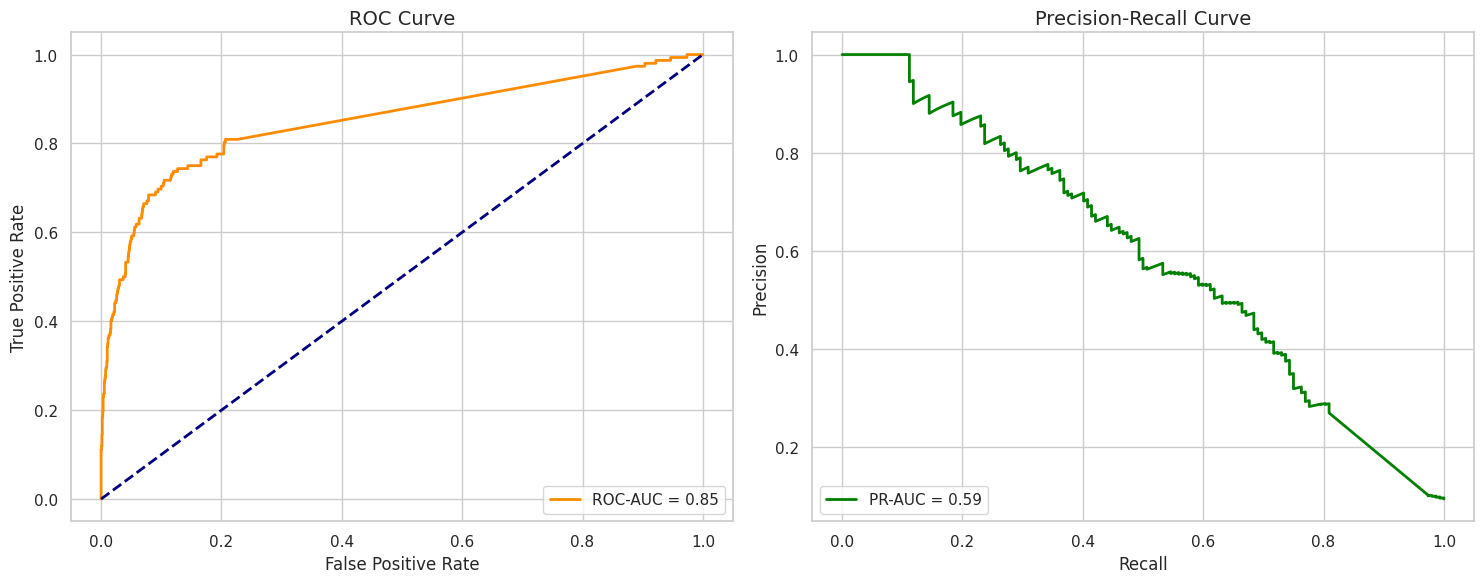

In [6]:
# Block 6: Advanced Evaluation (ROC & Precision-Recall Curves)
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, roc_curve

# 1. Prepare Data
# Ensure we have binary labels for calculation (Yes=1, No=0)
y_test_bin = (y_test == "Yes").astype(int)

# 2. Calculate PR-AUC
precision, recall, _ = precision_recall_curve(y_test_bin, y_proba_best)
pr_auc = auc(recall, precision)

print(f"Selected Model: {best_model_name}")
print(f"PR-AUC Score:   {pr_auc:.4f}")

# 3. Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test_bin, y_proba_best)
ax1.plot(fpr, tpr, label=f"ROC-AUC = {results.loc[best_model_name, 'roc_auc']:.2f}", color='darkorange', lw=2)
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_title("ROC Curve", fontsize=14)
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.legend(loc="lower right")

# Plot Precision-Recall Curve
ax2.plot(recall, precision, label=f"PR-AUC = {pr_auc:.2f}", color='green', lw=2)
ax2.set_title("Precision-Recall Curve", fontsize=14)
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.legend(loc="lower left")

plt.tight_layout()
plt.show()

In [7]:
# Block 7: Error Analysis (False Positives & False Negatives)

# 1. Create a DataFrame for Analysis
# We join the test features with the actual labels and our predictions
analysis_df = X_test.copy()
analysis_df['Actual'] = y_test
analysis_df['Predicted'] = y_pred_best
analysis_df['Prob_Fraud'] = y_proba_best

# 2. Identify Errors
# False Positives: Model said 'Yes' (Fraud), but actually 'No' (Legit)
fp_df = analysis_df[(analysis_df['Actual'] == 'No') & (analysis_df['Predicted'] == 'Yes')].sort_values(by='Prob_Fraud', ascending=False)

# False Negatives: Model said 'No' (Legit), but actually 'Yes' (Fraud)
fn_df = analysis_df[(analysis_df['Actual'] == 'Yes') & (analysis_df['Predicted'] == 'No')].sort_values(by='Prob_Fraud', ascending=True)

print(f"Found {len(fp_df)} False Positives and {len(fn_df)} False Negatives.")

# 3. Display Case Studies (Top 2 of each)
print("\n" + "="*80)
print("CASE STUDY: FALSE POSITIVES (Legitimate Providers flagged as Fraud)")
print("These are providers the model is 'most confident' are fraud, but they are not.")
print("Look for high claim counts or unusual patterns that might look like fraud.")
display(fp_df.head(2))

print("\n" + "="*80)
print("CASE STUDY: FALSE NEGATIVES (Fraud Providers missed by Model)")
print("These are fraud providers the model thought were safe.")
display(fn_df.head(2))

Found 154 False Positives and 44 False Negatives.

CASE STUDY: FALSE POSITIVES (Legitimate Providers flagged as Fraud)
These are providers the model is 'most confident' are fraud, but they are not.
Look for high claim counts or unusual patterns that might look like fraud.


,inp_InscClaimAmtReimbursed_mean,inp_InscClaimAmtReimbursed_sum,inp_InscClaimAmtReimbursed_min,inp_InscClaimAmtReimbursed_max,inp_DeductibleAmtPaid_mean,inp_DeductibleAmtPaid_sum,inp_DeductibleAmtPaid_min,inp_DeductibleAmtPaid_max,inp_ClmProcedureCode_1_mean,inp_ClmProcedureCode_1_sum,...,out_ClmProcedureCode_5_max,out_ClmProcedureCode_6_mean,out_ClmProcedureCode_6_sum,out_ClmProcedureCode_6_min,out_ClmProcedureCode_6_max,out_n_claims,out_n_bene,Actual,Predicted,Prob_Fraud
3932,11378.260870,1308500.0,0.0,57000.0,1068.0,121752.0,1068.0,1068.0,5595.237288,330119.0,...,4139.0,NaN,0.0,NaN,NaN,115.0,95.0,No,Yes,0.999988
361,9256.160714,1036690.0,0.0,57000.0,1068.0,117480.0,1068.0,1068.0,5702.866667,342172.0,...,4139.0,NaN,0.0,NaN,NaN,112.0,103.0,No,Yes,0.999978



CASE STUDY: FALSE NEGATIVES (Fraud Providers missed by Model)
These are fraud providers the model thought were safe.


,inp_InscClaimAmtReimbursed_mean,inp_InscClaimAmtReimbursed_sum,inp_InscClaimAmtReimbursed_min,inp_InscClaimAmtReimbursed_max,inp_DeductibleAmtPaid_mean,inp_DeductibleAmtPaid_sum,inp_DeductibleAmtPaid_min,inp_DeductibleAmtPaid_max,inp_ClmProcedureCode_1_mean,inp_ClmProcedureCode_1_sum,...,out_ClmProcedureCode_5_max,out_ClmProcedureCode_6_mean,out_ClmProcedureCode_6_sum,out_ClmProcedureCode_6_min,out_ClmProcedureCode_6_max,out_n_claims,out_n_bene,Actual,Predicted,Prob_Fraud
3878,7333.333333,22000.0,5000.0,12000.0,1068.0,3204.0,1068.0,1068.0,5877.671429,0.0,...,4139.0,NaN,0.0,NaN,NaN,3.0,2.0,Yes,No,0.086929
4449,12000.000000,12000.0,12000.0,12000.0,1068.0,1068.0,1068.0,1068.0,9671.000000,9671.0,...,4139.0,NaN,0.0,NaN,NaN,1.0,1.0,Yes,No,0.132655


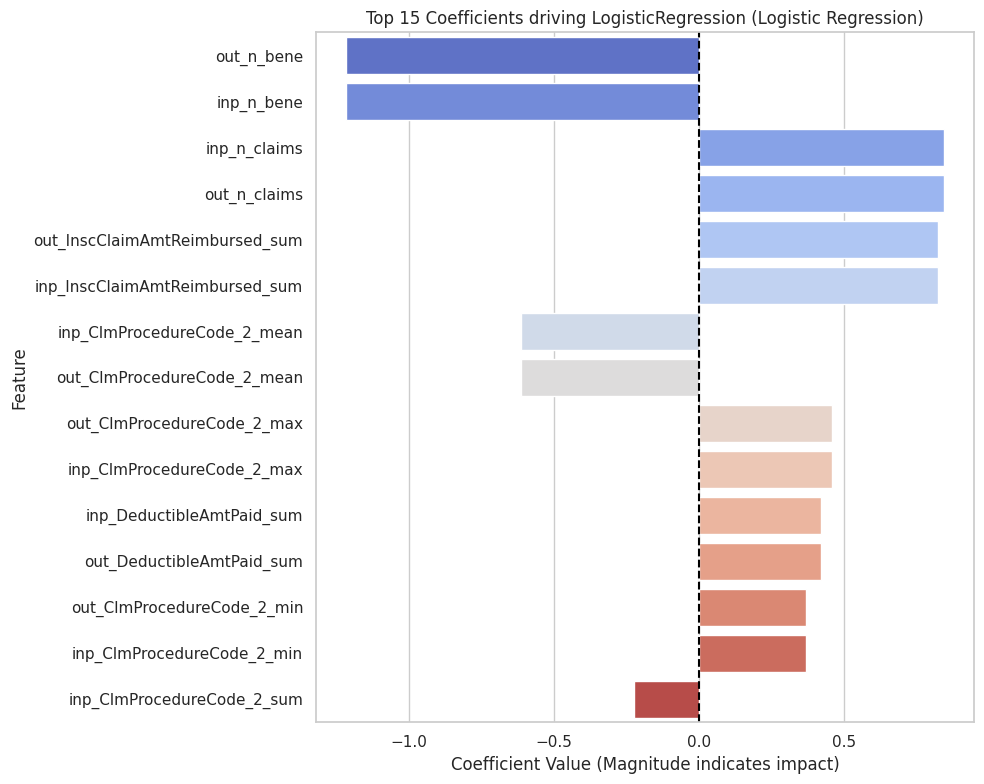

In [8]:
# Block 8: Feature Importance (Global Explainability) - Corrected

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def get_feature_names(model, input_features):
    """
    Helper to get feature names out of a pipeline.
    Handles cases where Imputer drops columns.
    """
    try:
        # Modern sklearn way: ask the steps before the classifier for output names
        return model[:-1].get_feature_names_out(input_features)
    except AttributeError:
        # Fallback: return input features (assuming no columns dropped)
        return input_features

# 1. Get the correct feature names that match the model internals
# We pass X.columns so the pipeline knows the original names
final_feature_names = get_feature_names(best_model, X.columns)

# 2. Check if the model has feature importances (Tree-based)
if hasattr(best_model.named_steps['clf'], 'feature_importances_'):
    # Extract importances for Random Forest
    importances = best_model.named_steps['clf'].feature_importances_

    # Create DataFrame
    feat_imp = pd.DataFrame({'Feature': final_feature_names, 'Importance': importances})
    feat_imp = feat_imp.sort_values(by='Importance', ascending=False).head(15) # Top 15

    # Plot
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
    plt.title(f"Top 15 Features driving {best_model_name} (Random Forest)")
    plt.xlabel("Gini Importance")
    plt.tight_layout()
    plt.show()

# 3. Check if the model has coefficients (Linear/Logistic)
elif hasattr(best_model.named_steps['clf'], 'coef_'):
    # Extract coefficients for Logistic Regression
    importances = best_model.named_steps['clf'].coef_[0]

    # Safety check for length mismatch (in case the helper above failed)
    if len(final_feature_names) != len(importances):
        print(f"[WARNING] Length mismatch fixes: Features={len(final_feature_names)}, Coefs={len(importances)}")
        # Truncate to the smaller length to prevent crash (emergency fix)
        min_len = min(len(final_feature_names), len(importances))
        final_feature_names = final_feature_names[:min_len]
        importances = importances[:min_len]

    # Create DataFrame
    feat_imp = pd.DataFrame({'Feature': final_feature_names, 'Coefficient': importances})
    feat_imp['Abs_Coeff'] = feat_imp['Coefficient'].abs()
    feat_imp = feat_imp.sort_values(by='Abs_Coeff', ascending=False).head(15)

    # Plot
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Coefficient', y='Feature', data=feat_imp, palette='coolwarm')
    plt.title(f"Top 15 Coefficients driving {best_model_name} (Logistic Regression)")
    plt.axvline(x=0, color='black', linestyle='--')
    plt.xlabel("Coefficient Value (Magnitude indicates impact)")
    plt.tight_layout()
    plt.show()

In [9]:
# Block 9: Generate predictions for full data and save artifacts for evaluation

from pathlib import Path
from joblib import dump

# 1) Rebuild X, y for the full dataset (for clarity)
X_full = provider_df[feature_columns].copy()
y_full = provider_df[target_column].copy()

print("X_full shape:", X_full.shape)
print("y_full shape:", y_full.shape)

# 2) Predict with the best model on the full data
y_pred_full = best_model.predict(X_full)
y_proba_full = best_model.predict_proba(X_full)[:, 1]

# 3) Build a results DataFrame
results_df = provider_df[[id_column, target_column]].copy()
results_df["pred_label"] = y_pred_full
results_df["pred_proba"] = y_proba_full

# Mark which rows were in train vs test split
train_idx = set(X_train.index)
test_idx = set(X_test.index)

def split_label(idx):
    if idx in train_idx:
        return "train"
    elif idx in test_idx:
        return "test"
    else:
        return "unused"

results_df["split"] = [split_label(i) for i in results_df.index]

print("\nHead of results_df:")
display(results_df.head())

# 4) Create output directory
output_dir = Path("model_outputs")
output_dir.mkdir(exist_ok=True)

# 5) Save predictions
preds_path = output_dir / "provider_predictions.csv"
results_df.to_csv(preds_path, index=False)
print("\nSaved predictions to:")
print(preds_path.resolve())

# 6) Save the best model
model_path = output_dir / f"best_model_{best_model_name}.joblib"
dump(best_model, model_path)
print("\nSaved best model to:")
print(model_path.resolve())

print("\nDone. You can now use provider_predictions.csv and the saved model in 03_evaluation.ipynb.")


X_full shape: (5410, 68)
y_full shape: (5410,)

Head of results_df:


,Provider,Target,pred_label,pred_proba,split
0,PRV51001,No,Yes,0.771895,train
1,PRV51003,Yes,Yes,0.987982,test
2,PRV51004,No,No,0.214939,train
3,PRV51005,Yes,No,0.214939,test
4,PRV51007,No,No,0.225342,test



Saved predictions to:
/content/model_outputs/provider_predictions.csv

Saved best model to:
/content/model_outputs/best_model_LogisticRegression.joblib

Done. You can now use provider_predictions.csv and the saved model in 03_evaluation.ipynb.


# Summary
- Loaded clean features
- Split into train/test
- Trained Logistic Regression
- Evaluated model
- Saved best model (joblib)
- Saved feature metadata
